## Трансформер. Механизм внимания

План на сегодня:
- Верхнеуровневый взгляд на блок трансформера
- Разбор устройства модуля внимания multi-head attention (MHA)
- Постобработка выходов multi-head attention
- Перестановочная эквивариантность (permutation equivariance) и позиционное кодирование

### 1. Механизм внимания

Пример: в языке значение омонимов зависит от других слов в различной степени:


I swam across the river to get to the other <span style="color:cyan">bank</span>.

I walked across the road to get cash from the <span style="color:cyan">bank</span>.

<img src="../attachments/attention_example.png" style="background:white" width="600"/>

Обозначения:

$\mathbf{X} \in \mathbb{R}^{N \times d}$ - набор токенов

$\mathbf{Y} = \text{TransformerLayer}[\mathbf{X}]$ - преобразованные трансформером токены, $\mathbf{Y} \in \mathbb{R}^{N \times d}$

#### 1.1. Scaled dot-product self-attention

Терминология:
- Каждый токен несёт в себе некую информацию (**value**)
- Содержимое токена кодируется ключом (**key**)
- Каждый токен формирует запрос (**query**) к други токенам
- Чем лучше ключ соответствует запросу, тем больший вес получит информация


$y_i = \sum_{j=1}^N a_{ij} x_j, \quad \sum_{j=1}^N a_{ij} = 1, \quad a_{ij} \geq 0$

Начнём с простого сценария, когда токен $x_i$ сам выполняет все три функции: он является и значением, и ключом, и запросом

Хотим, чтобы вес $a_{ij}$ зависел от сходства $x_i$ и $x_j$, например $a_{ij} \sim x_i^T x_j$

Функция, которая обеспечит нужные ограничения на $a_{ij}$, нам уже знакома:

$$a_{ij} = \frac{\exp(x_i^T x_j)}{\sum_{j' = 1}^N \exp(x_i^T x_{j'})}$$

В матричной нотации получается
$\mathbf{Y} = \text{Softmax}[\mathbf{X} \mathbf{X}^T] \mathbf{X}$

**Вопрос**: что можно сказать про зависимость $\mathbf{Y}$ от $\mathbf{X}$? Она линейна?

In [1]:
import torch
from torch import Tensor, nn

# import matplotlib.pyplot as plt

N = 5
D = 4

X = torch.randn(N, D)
attention_weights = (X @ X.T).softmax(-1)
Y = attention_weights @ X
print(Y.shape)
# plt.imshow(attention_weights, interpolation="nearest")

torch.Size([5, 4])


Добавим гибкости:

$\mathbf{Q} = \mathbf{X} \mathbf{W}^{(q)} \quad$
$\mathbf{K} = \mathbf{X} \mathbf{W}^{(k)} \quad$
$\mathbf{V} = \mathbf{X} \mathbf{W}^{(v)}$

<img src="../attachments/sa_output.png" style="background:white" width="600"/>

Последний штрих: отмасштабируем матрицу $\mathbf{Q} \mathbf{K}^T$ на $\sqrt{D_k}$. Для чего это нужно?

<img src="../attachments/scaled_dot_product_attention.png" style="background:white" width="600"/>

<img src="../attachments/sa_flow.png" style="background:white" height="275"/>

В реализации осталось только добавить размерность батча:

In [2]:
B = 3
N = 5
D = 4

X = torch.randn(B, N, D)
# (B, N, D) x (B, D, N) -> (B, N, N)
attention_weights = torch.bmm(X, X.permute(0, 2, 1)).softmax(-1)
Y = torch.bmm(attention_weights, X)
print(attention_weights.shape)
print(Y.shape)

torch.Size([3, 5, 5])
torch.Size([3, 5, 4])


In [3]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.W_q = nn.Linear(input_dim, hidden_dim)
        self.W_k = nn.Linear(input_dim, hidden_dim)
        self.W_v = nn.Linear(input_dim, input_dim)

    def forward(self, x: Tensor) -> Tensor:
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        _, _, D_k = k.shape

        scores = torch.bmm(q, k.permute(0, 2, 1)) / D_k**0.5
        attention_weights = scores.softmax(-1)
        return torch.bmm(attention_weights, v)


ScaledDotProductAttention(4, 3).forward(X).shape

torch.Size([3, 5, 4])

#### 1.1. Multi-head attention

Возможны несколько различных аспектов внимания: значение слов, грамматические конструкции, стилистика.

Поэтому используем несколько независимых "голов" внимания.


<img src="../attachments/mha_flow.png" style="background:white" width="600"/>

<img src="../attachments/mha.png" style="background:white" width="600"/>

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, n_heads: int) -> None:
        super().__init__()
        self.heads = nn.ModuleList(
            [ScaledDotProductAttention(input_dim, hidden_dim) for i in range(n_heads)]
        )
        self.W_o = nn.Linear(n_heads * input_dim, input_dim)

    def forward(self, x: Tensor) -> Tensor:
        h = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.W_o(h)


MultiHeadAttention(4, 5, 5).forward(X).shape

torch.Size([3, 5, 4])

### 2. Постпроцессинг токенов

Поверх внимания добавим ещё несколько модулей:
- skip connection
- layer normalization
- перцептрон для выходов из multi-head attention

<img src="../attachments/transformer_layer.png" style="background:white" width="600"/>

In [5]:
X.shape

torch.Size([3, 5, 4])

In [6]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, n_heads: int) -> None:
        super().__init__()
        self.mha = MultiHeadAttention(input_dim, hidden_dim, n_heads)
        self.norm1 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim, input_dim),
        )
        self.norm2 = nn.LayerNorm(input_dim)

    def forward(self, x: Tensor) -> Tensor:
        z = self.norm1(self.mha(x) + x)
        return self.norm2(self.mlp(z) + z)


SelfAttentionLayer(4, 5, 5).forward(X).shape

torch.Size([3, 5, 4])

### 3. Позиционное кодирование

Наш `SelfAttentionLayer` является эквивариантным по отношению к перестановкам входных токенов:

$\text{SelfAttentionLayer}[\pi(\mathbf{X})] = \pi(\text{SelfAttentionLayer}[\mathbf{X}])$

Это отличное свойство, если мы работаем с множествами, где нет определённого порядка элементов.

Но для нас порядок важен, так что нужен спобоб эту информацию передать вместе с токеном, не меняя архитектуру.

Наши новые токены будут формироваться как $\tilde{\mathbf{x}}_i = \mathbf{x}_i + \mathbf{r}_i$, где $\mathbf{r}_i$ — вектор, кодирующий позицию

Вариантов много, в оригинальной статье про трансформер было такое:

d - желаемый размер вектора, кодирующего позицию

for 
$
i \in [1, d] \\
\begin{aligned}
r(t, 2i) = \sin \left( \frac{t}{L^{2i / d}} \right) \\
r(t, 2i + 1) = \cos \left( \frac{t}{L^{2i / d}} \right)
\end{aligned}
$

In [7]:
import math


class PositionalEncoding(nn.Module):
    pe: Tensor

    def __init__(self, encoding_size: int, L: int = 10000, max_len: int = 1000):
        super().__init__()
        # можно было бы считать налету, но мы заготовим буфер под любую допустимую длину
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, encoding_size, 2) * (-math.log(L) / encoding_size)
        )
        pe = torch.zeros(max_len, encoding_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, t: Tensor) -> Tensor:
        return self.pe[t]

Посмотрим на примере векторов размерности $d=32$ и $L = 30$

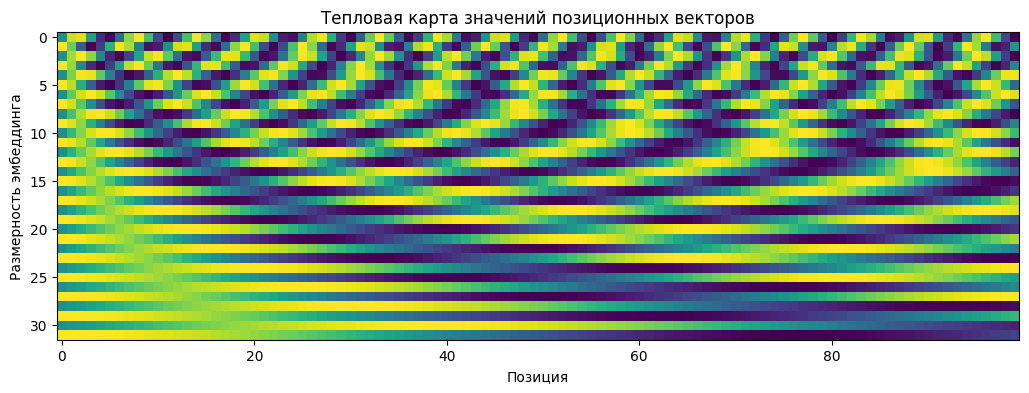

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

plt.imshow(PositionalEncoding(32, L=30, max_len=100)(torch.arange(100)).T)
plt.title("Тепловая карта значений позиционных векторов")
plt.xlabel("Позиция")
plt.ylabel("Размерность эмбеддинга")
plt.show()

Объединим получение эмбеддингов токенов и позиций в один модуль:

In [9]:
class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, pad_token_id: int = 0, max_position: int = 100):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_token_id)
        self.position_embeddings = PositionalEncoding(hidden_size, max_len=max_position)
        # self.position_embeddings = nn.Embedding(max_position, hidden_size)

        self.register_buffer(
            "position_ids", torch.arange(max_position).expand((1, -1)), persistent=False
        )

    def forward(self, input_ids: Tensor) -> torch.Tensor:
        B, N = input_ids.size()
        position_ids = self.position_ids[:, : N]
        inputs_embeds = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        embeddings = inputs_embeds + position_embeddings
        return embeddings

Наконец, соберём минимальный трансформерный энкодер:

In [10]:
tokens = torch.randint(0, 20, size=(4, 10))
embeds = TransformerEmbeddings(vocab_size=20, hidden_size=8)
sa = SelfAttentionLayer(input_dim=8, hidden_dim=8, n_heads=2)

# получаем начальные токены
h = embeds.forward(tokens)
print(h.shape)

# применяем self-attention
h = sa.forward(h)
print(h.shape)

torch.Size([4, 10, 8])
torch.Size([4, 10, 8])
